True MI: 10.0


100%|██████████| 500/500 [00:51<00:00,  9.74it/s]


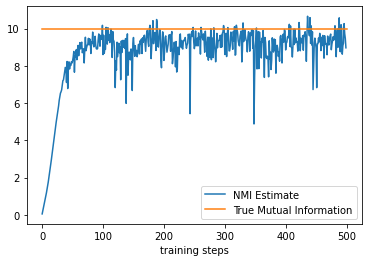

In [1]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
 
 
SIGNAL_NOISE = 0.2
SIGNAL_POWER = 3
 
data_dim = 5
num_instances = 20000
 
 
def gen_x(num, dim):
    return np.random.normal(0., np.sqrt(SIGNAL_POWER), [num, dim])
 
 
def gen_y(x, num, dim):
    return x + np.random.normal(0., np.sqrt(SIGNAL_NOISE), [num, dim])
 
 
def true_mi(power, noise, dim):
    return dim * 0.5 * np.log2(1 + power/noise)
 
 
mi = true_mi(SIGNAL_POWER, SIGNAL_NOISE, data_dim)
print('True MI:', mi)
 
 
hidden_size = 50
n_epoch = 500
 
 
class NMI(nn.Module):
    def __init__(self, hidden_size=10):
        super(NMI, self).__init__()
        self.layers = nn.Sequential(nn.Linear(2 * data_dim, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, 1))
 
    def forward(self, x, y):
        batch_size = x.size(0)
        tiled_x = torch.cat([x, x, ], dim=0)
        idx = torch.randperm(batch_size)
 
        shuffled_y = y[idx]
        concat_y = torch.cat([y, shuffled_y], dim=0)
        inputs = torch.cat([tiled_x, concat_y], dim=1)
        logits = self.layers(inputs)
 
        pred_xy = logits[:batch_size]
        pred_x_y = logits[batch_size:]
        loss = - np.log2(np.exp(1)) * (torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y))))
        # compute loss, you'd better scale exp to bit
        return loss
 
 
model = NMI(hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
plot_loss = []
all_mi = []
for epoch in tqdm(range(n_epoch)):
    x_sample = gen_x(num_instances, data_dim)
    y_sample = gen_y(x_sample, num_instances, data_dim)
 
    x_sample = torch.from_numpy(x_sample).float()
    y_sample = torch.from_numpy(y_sample).float()
 
    loss = model(x_sample, y_sample)
 
    model.zero_grad()
    loss.backward()
    optimizer.step()
    all_mi.append(-loss.item())
 
 
fig, ax = plt.subplots()
ax.plot(range(len(all_mi)), all_mi, label='NMI Estimate')
ax.plot([0, len(all_mi)], [mi, mi], label='True Mutual Information')
ax.set_xlabel('training steps')
ax.legend(loc='best')
plt.show()